# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de La Palma

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')


    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color_isla)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=10),   train_s.index.union(test.index)[::10], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_LaPalma = datos_islas[datos_islas['isla'] == 'LA PALMA'].copy() 


datos_LaPalma = datos_LaPalma.sort_values(by='fecha')    # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_LaPalma.set_index('fecha', inplace=True)           # Añadimos como índice de los datos la fecha

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'cyan'       # Color de la isla en las visualizaciones
isla = 'La Palma'         # Nombre de la isla para las visualizaciones    

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos

datos_LaPalma_arima_uni = datos_LaPalma[objetivo]               # Datos modelo Univariable
datos_LaPalma_arima_mult_covid = datos_LaPalma[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_LaPalma_arima_mult_atm = datos_LaPalma[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_LaPalma_arima_total = datos_LaPalma.copy()                # Datos modelo Multivariable con todos los datos

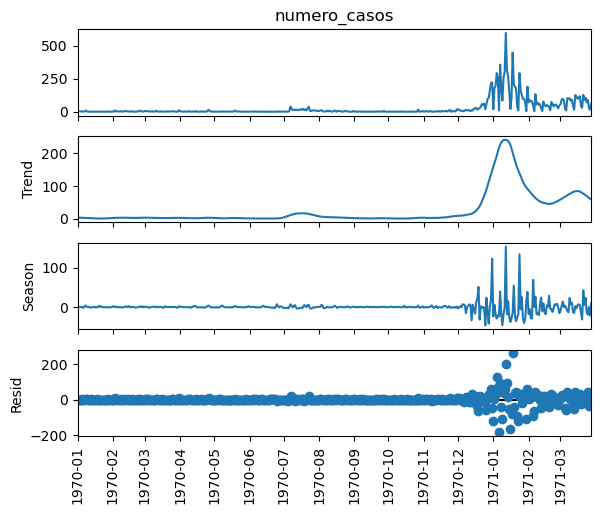

In [6]:
visualizar_STL(datos_LaPalma_arima_uni)

In [7]:
visualizar_adf(datos_LaPalma_arima_uni)

ADF p-value:0.007509884473720356


<Figure size 1600x1000 with 0 Axes>

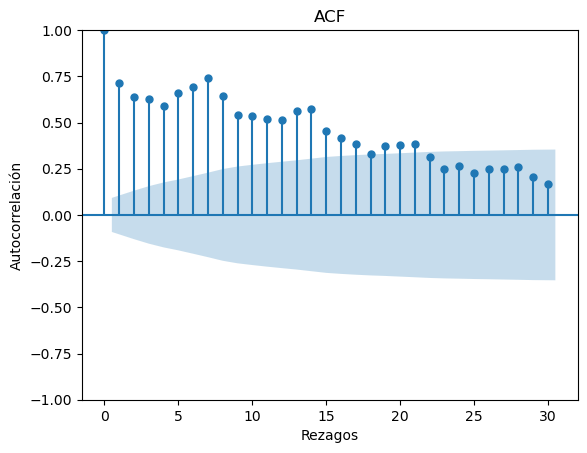

In [8]:
visualizar_acf(datos_LaPalma_arima_uni, 30)

<Figure size 1600x600 with 0 Axes>

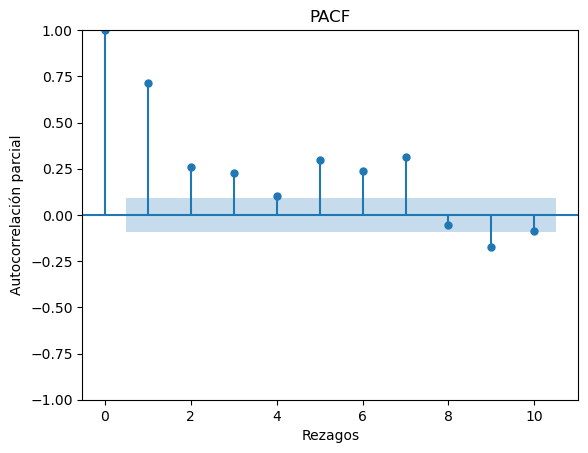

In [9]:
visualizar_pacf(datos_LaPalma_arima_uni, 10)

In [10]:
# Parámetros del modelo ARIMA
p = 5   # Parámetro Autorregresivo (AR)
d = 0   # Parámetro Integrado (I)
q = 5   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

In [11]:
# Conjuntos de entrenamiento y test
train = datos_LaPalma_arima_uni.iloc[:len(datos_LaPalma_arima_uni) - n_dias]
test =  datos_LaPalma_arima_uni.iloc[len(datos_LaPalma_arima_uni) - n_dias:]

In [12]:
arima_LaPalma = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_LaPalma = arima_LaPalma.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
visualizar_bic_aic(modelo_arima_LaPalma)

BIC del modelo ARIMA: 4473.985467447122
AIC del modelo ARIMA: 4424.88974886219


In [14]:
pred = modelo_arima_LaPalma.forecast(steps=n_dias)

In [15]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 44, número de casos predichos 63.041766698184034
2022-03-20: número de casos reales 30, número de casos predichos 58.71594280335573
2022-03-21: número de casos reales 127, número de casos predichos 85.86053033432472
2022-03-22: número de casos reales 90, número de casos predichos 104.91709158727389
2022-03-23: número de casos reales 106, número de casos predichos 116.68928777516611
2022-03-24: número de casos reales 70, número de casos predichos 103.43391064518175
2022-03-25: número de casos reales 89, número de casos predichos 81.89185958166206
2022-03-26: número de casos reales 26, número de casos predichos 63.463137666752345
2022-03-27: número de casos reales 15, número de casos predichos 64.07991620058219
2022-03-28: número de casos reales 63, número de casos predichos 79.82161175320762


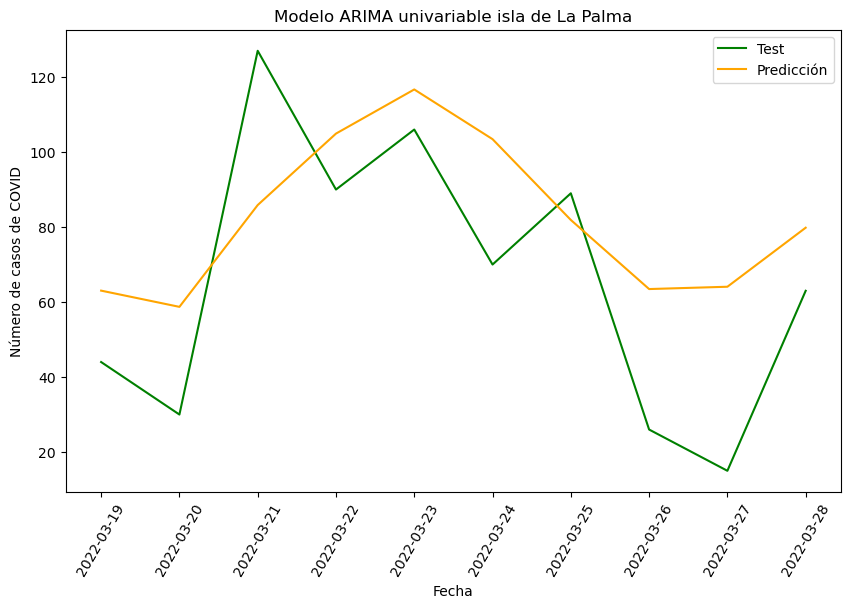

In [16]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

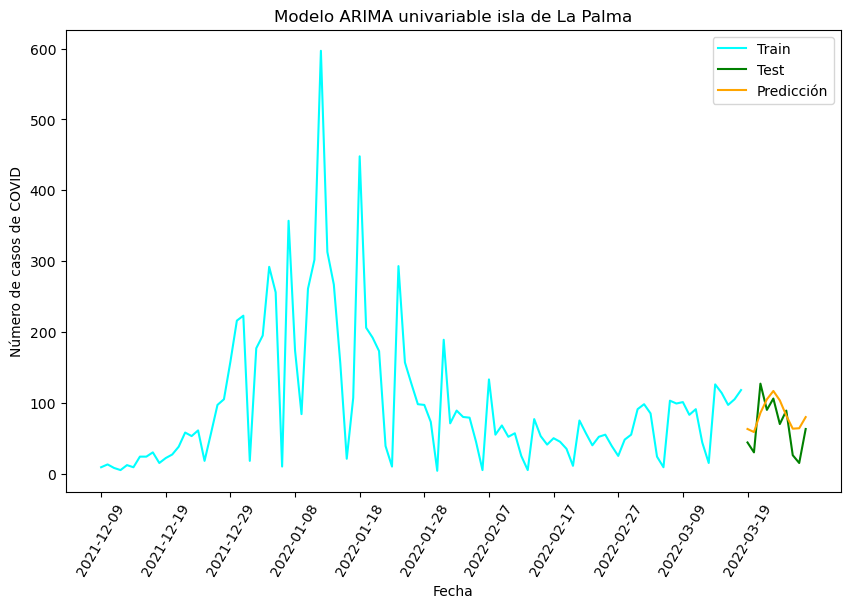

In [17]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit, color_isla)

In [18]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 848.0074230316786
Error absoluto medio (MAE) del modelo: 25.84102752137169
Raíz del error cuadrático medio (RMSE) del modelo: 29.120567010820352


# Modelo ARIMA multivariable con variables de pandemia

In [19]:
train = datos_LaPalma_arima_mult_covid.iloc[:len(datos_LaPalma_arima_mult_covid) - n_dias]
test =  datos_LaPalma_arima_mult_covid.iloc[len(datos_LaPalma_arima_mult_covid) - n_dias:]

In [20]:
arima_LaPalma = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_LaPalma = arima_LaPalma.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [21]:
visualizar_bic_aic(modelo_arima_LaPalma)

BIC del modelo ARIMA: 4408.965544162447
AIC del modelo ARIMA: 4343.504586049204


In [22]:
pred = modelo_arima_LaPalma.forecast(steps=n_dias, exog=test[variables_covid])

In [23]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 44, número de casos predichos 51.491409529756616
2022-03-20: número de casos reales 30, número de casos predichos 44.76031446583566
2022-03-21: número de casos reales 127, número de casos predichos 112.459502811559
2022-03-22: número de casos reales 90, número de casos predichos 131.94168857525932
2022-03-23: número de casos reales 106, número de casos predichos 132.38925773061956
2022-03-24: número de casos reales 70, número de casos predichos 138.5729408406388
2022-03-25: número de casos reales 89, número de casos predichos 117.43782836303723
2022-03-26: número de casos reales 26, número de casos predichos 51.808562234834575
2022-03-27: número de casos reales 15, número de casos predichos 44.84782044566191
2022-03-28: número de casos reales 63, número de casos predichos 74.20203702106646


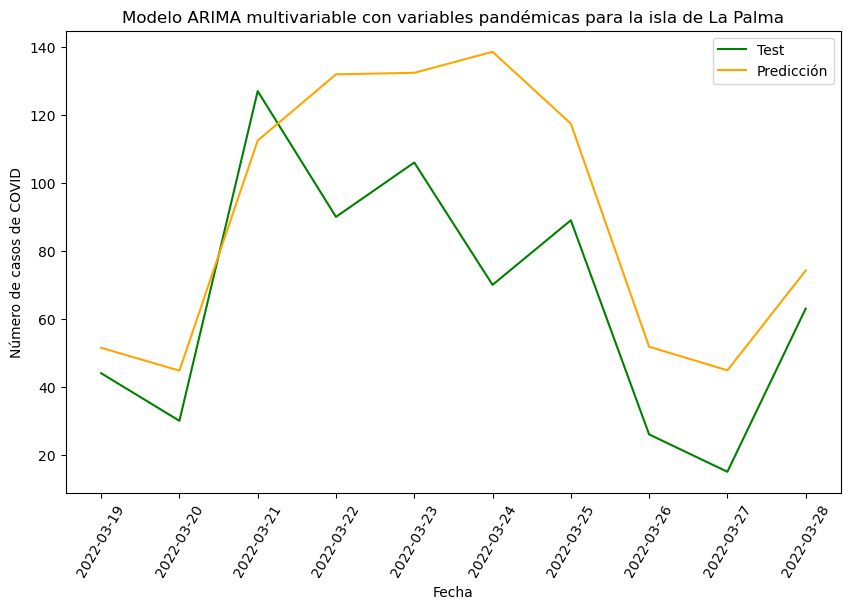

In [24]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [25]:
type(pred)

pandas.core.series.Series

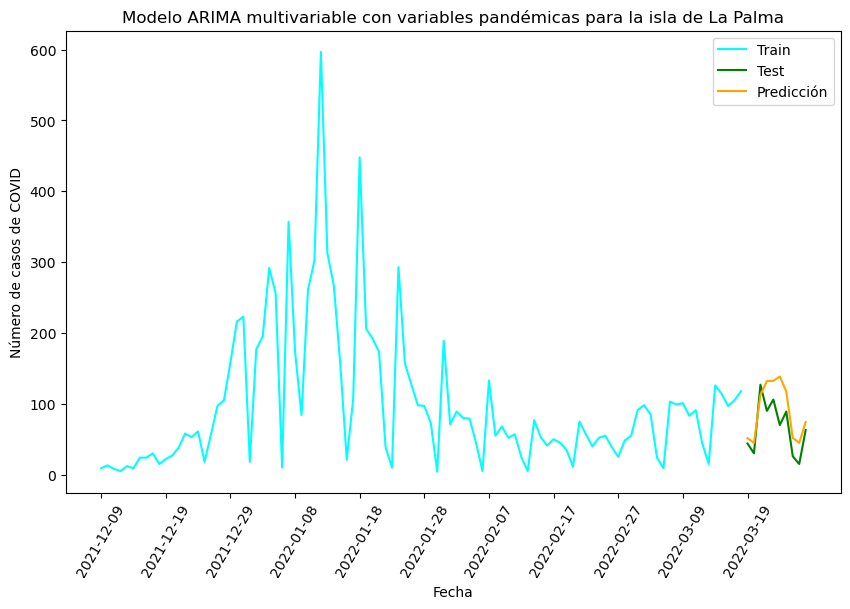

In [26]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla)

In [27]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1013.4330523423508
Error absoluto medio (MAE) del modelo: 26.899235639515116
Raíz del error cuadrático medio (RMSE) del modelo: 31.834463280262018


# Modelo ARIMA multivariable con variables atmosféricas

In [28]:
train = datos_LaPalma_arima_mult_atm.iloc[:len(datos_LaPalma_arima_mult_atm) - n_dias]
test =  datos_LaPalma_arima_mult_atm.iloc[len(datos_LaPalma_arima_mult_atm) - n_dias:]

In [29]:
arima_LaPalma = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_LaPalma = arima_LaPalma.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
visualizar_bic_aic(modelo_arima_LaPalma)

BIC del modelo ARIMA: 4502.3079285900285
AIC del modelo ARIMA: 4440.938280358863


In [31]:
pred = modelo_arima_LaPalma.forecast(steps=n_dias, exog=test[variables_atm])

In [32]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 44, número de casos predichos 58.23001421504338
2022-03-20: número de casos reales 30, número de casos predichos 60.12453327503357
2022-03-21: número de casos reales 127, número de casos predichos 77.47930944817543
2022-03-22: número de casos reales 90, número de casos predichos 99.91274751252097
2022-03-23: número de casos reales 106, número de casos predichos 105.50335611805434
2022-03-24: número de casos reales 70, número de casos predichos 97.60512740880324
2022-03-25: número de casos reales 89, número de casos predichos 90.98641929458532
2022-03-26: número de casos reales 26, número de casos predichos 74.90939292886367
2022-03-27: número de casos reales 15, número de casos predichos 62.19431872122366
2022-03-28: número de casos reales 63, número de casos predichos 74.89204280480924


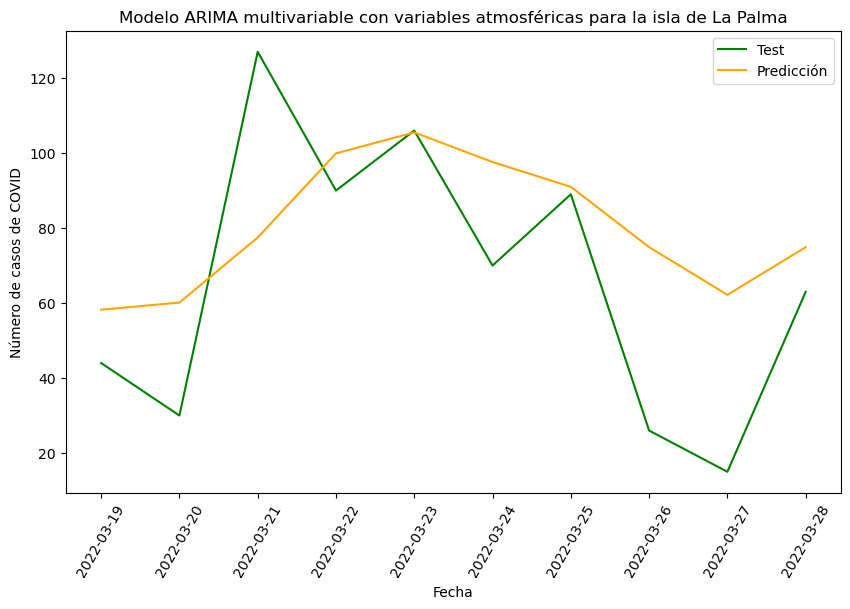

In [33]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

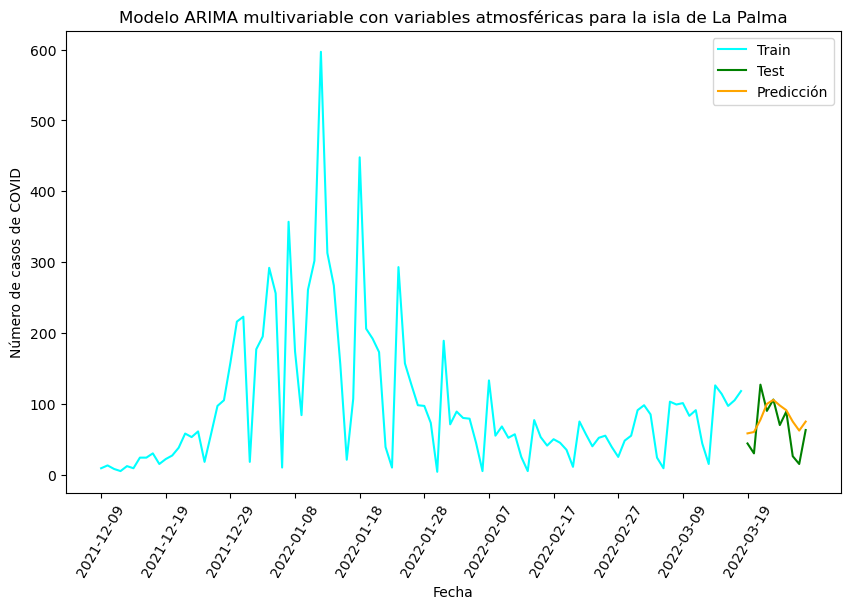

In [34]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla)

In [35]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 918.7630859892972
Error absoluto medio (MAE) del modelo: 24.187193059465322
Raíz del error cuadrático medio (RMSE) del modelo: 30.31110499452795


# Modelo ARIMA multivariable con todas las variables

In [36]:
train = datos_LaPalma_arima_total.iloc[:len(datos_LaPalma_arima_total) - n_dias]
test =  datos_LaPalma_arima_total.iloc[len(datos_LaPalma_arima_total) - n_dias:]

In [37]:
arima_LaPalma = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_LaPalma = arima_LaPalma.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
visualizar_bic_aic(modelo_arima_LaPalma)

BIC del modelo ARIMA: 4428.013884970823
AIC del modelo ARIMA: 4350.278997211347


In [39]:
pred = modelo_arima_LaPalma.forecast(steps=10, exog=test[variables])

In [40]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 44, número de casos predichos 56.22455680034575
2022-03-20: número de casos reales 30, número de casos predichos 44.97058082651901
2022-03-21: número de casos reales 127, número de casos predichos 107.76983552980819
2022-03-22: número de casos reales 90, número de casos predichos 131.6994215517225
2022-03-23: número de casos reales 106, número de casos predichos 123.93058005810235
2022-03-24: número de casos reales 70, número de casos predichos 131.79635383158558
2022-03-25: número de casos reales 89, número de casos predichos 114.1894792964892
2022-03-26: número de casos reales 26, número de casos predichos 48.225769613398434
2022-03-27: número de casos reales 15, número de casos predichos 42.468888343442316
2022-03-28: número de casos reales 63, número de casos predichos 77.25806224933142


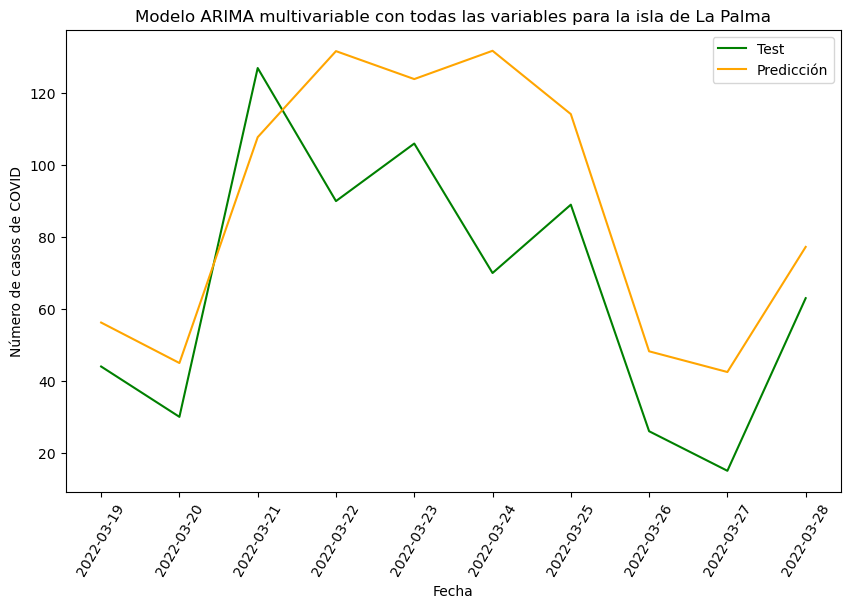

In [41]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

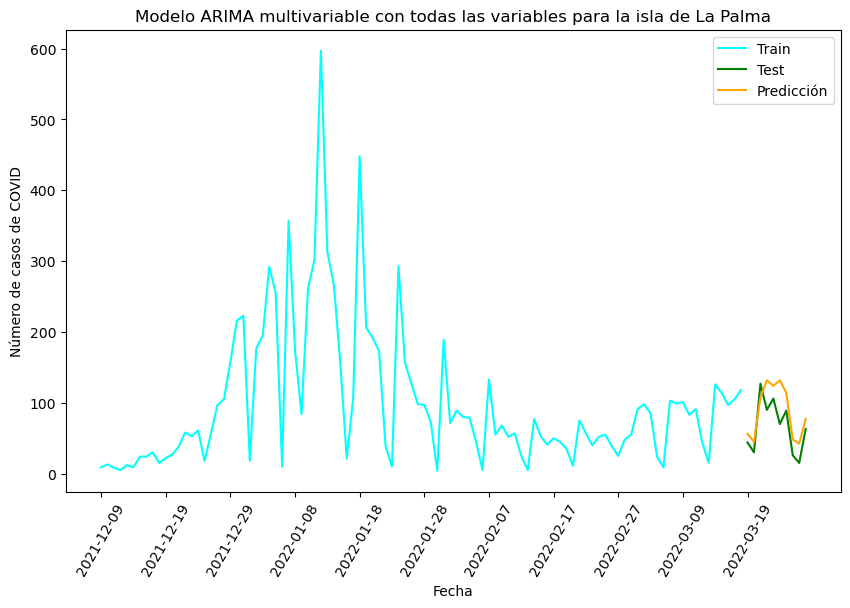

In [42]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit, color_isla)

In [43]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 870.882097871208
Error absoluto medio (MAE) del modelo: 25.699385704112835
Raíz del error cuadrático medio (RMSE) del modelo: 29.510711578530398
